# Notebook to Generate All Plots in the Paper

### Preliminaries

In [1]:
from eval_model_helpers import *
sys.path.append(os.path.join('..'))
from models.func_to_func2d_invasive import FNO2d
from util.utilities_module import *
from gen_GRF import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


In [2]:
# Plot defaults
# Set font default
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00',
                    '#000000']
matplotlib.rcParams['mathtext.rm'] = 'stix'
matplotlib.rcParams['mathtext.it'] = 'stix'
matplotlib.rcParams['mathtext.bf'] = 'stix'


matplotlib.rcParams["axes.formatter.limits"] = (-99, 99) #makes scientific notation threshold high
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' 'serif' 'Times
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r

# \usepackage{amsmath}
'''
'''

tickfontsize = 30
fontsize = 30
linewidth = 4
markersize = 15

SMALL_SIZE = tickfontsize
MEDIUM_SIZE = tickfontsize
BIGGER_SIZE = fontsize

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

shapes = ['o','s','^','D','*', 'x', 'P', 'h', 'v', '<', '>', 'X', 'd', 'p', '|', '_', '.', ',']



## Generate GRF Inputs for Various Values of s

In [3]:
# Generate data (GRF inputs)
s_vals = [0.5, 1.0, 1.5, 2.0]
# process input arguments
sizes = [32, 64, 128, 256, 512] #, 1024, 2048]
sample_count = 5
for s in s_vals:
    for n in range(sample_count):
        gfields = gaussian_random_field(s, sizes = sizes)
        # save GRF
        for i, size in enumerate(sizes):
            Z = gfields[i]
            pkl.dump(Z, open("../data/GRF_s"+  str(s) + "_GRF_size_" + str(size) + "_" + str(n) + ".pkl", "wb"))

#### Plot GRFS

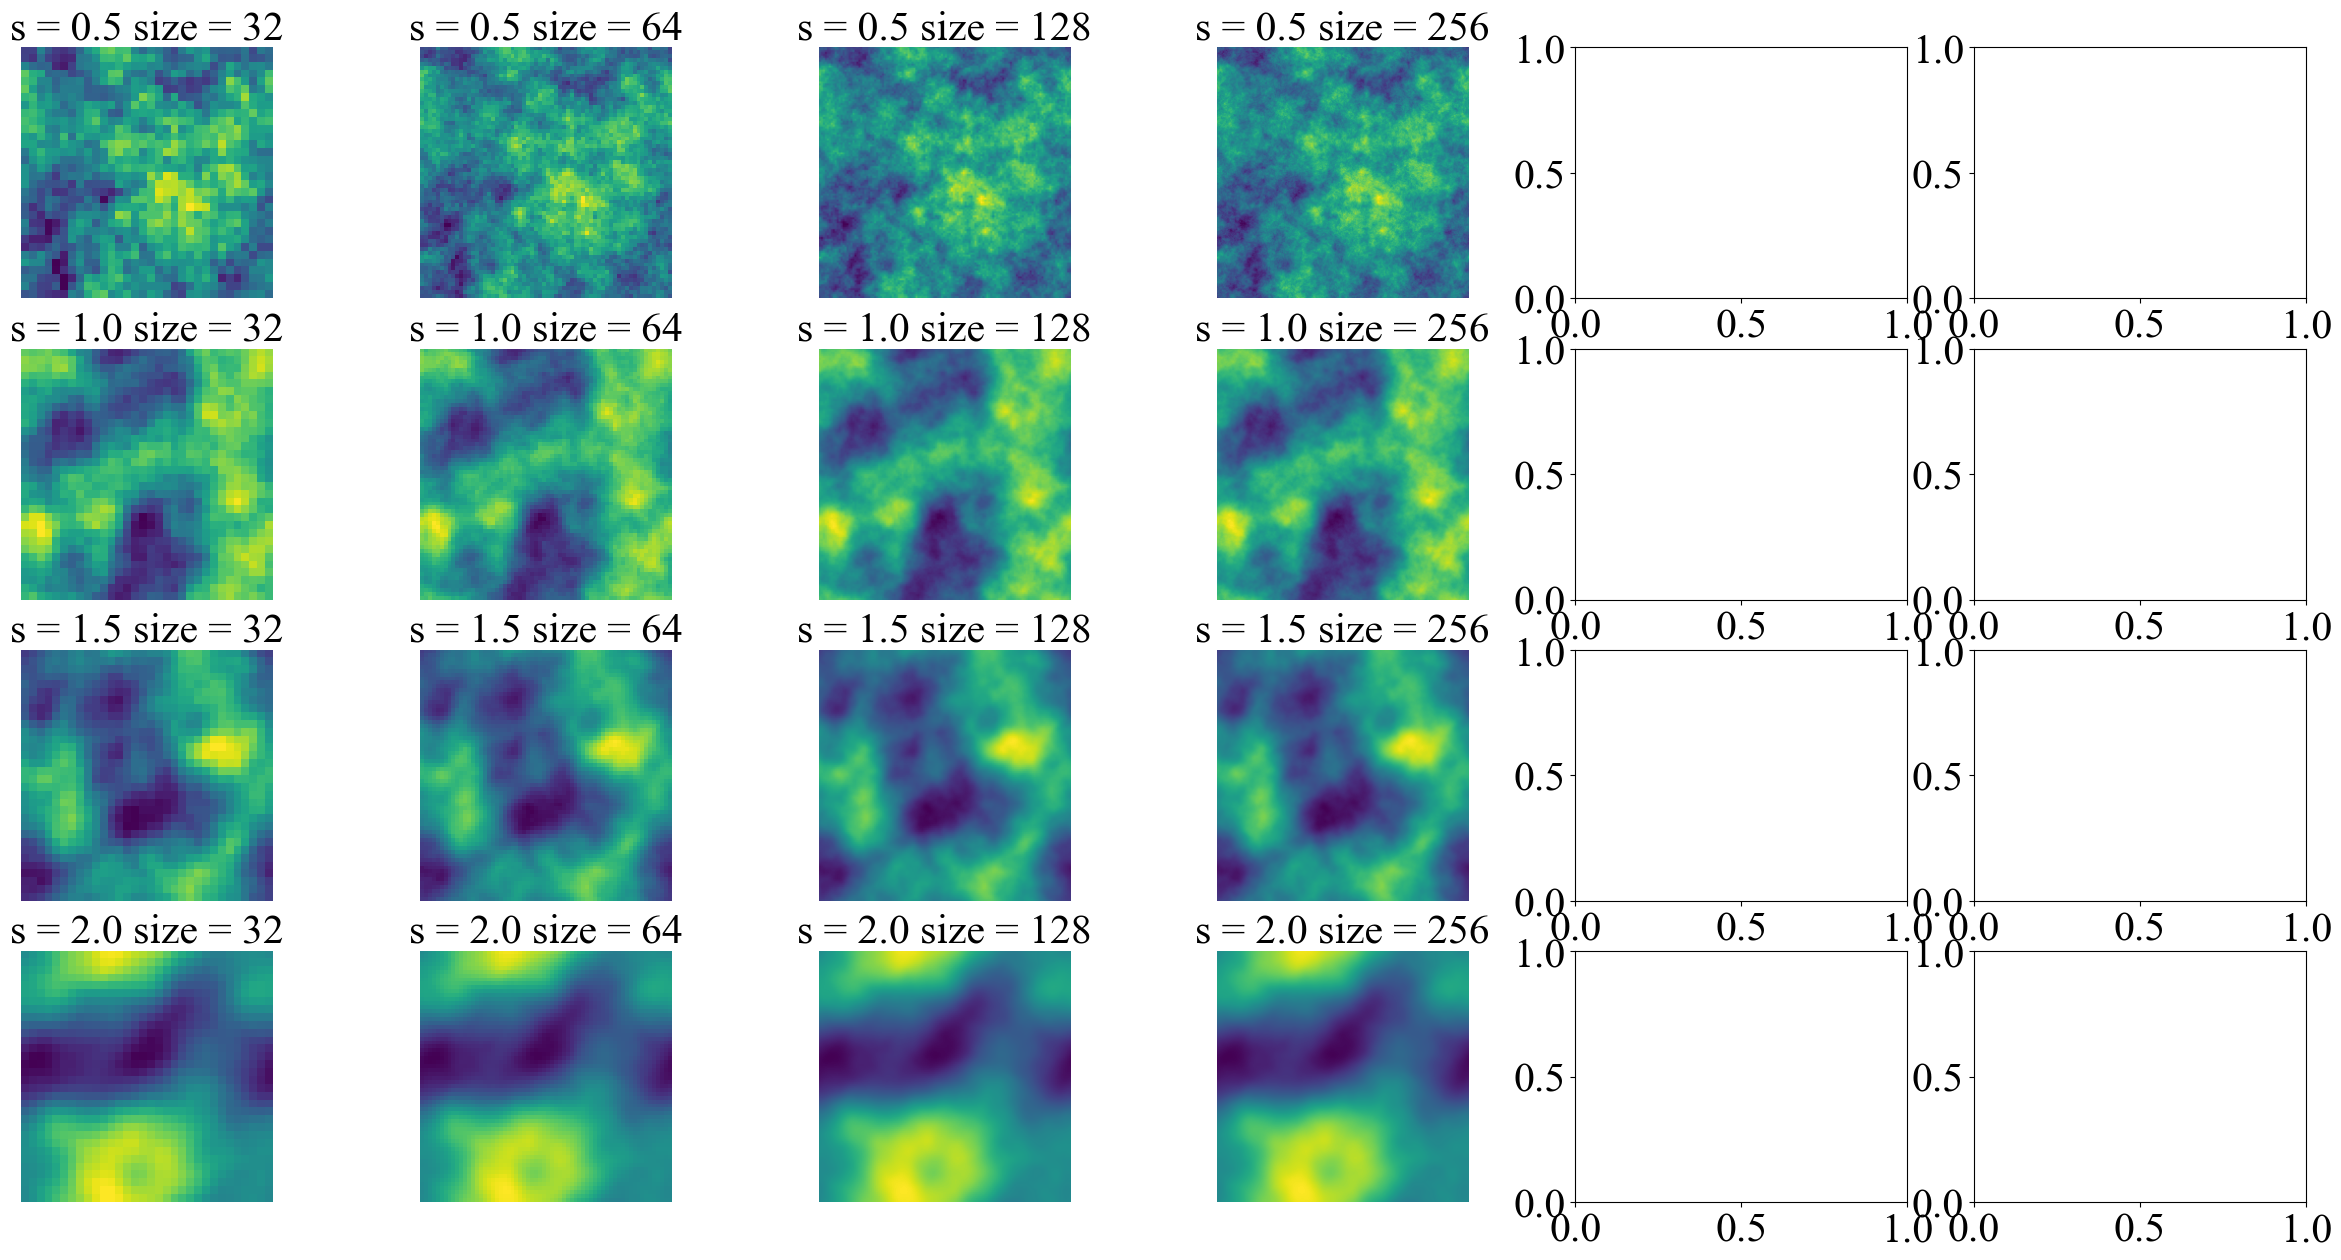

In [4]:
# Plot GRFs
fig, ax = plt.subplots(4, 6, figsize=(30, 15))
for i, s in enumerate(s_vals):
    for j, size in enumerate(sizes[:-1]):
        Z = pkl.load(open("../data/GRF_s"+  str(s) + "_GRF_size_" + str(size) + "_0.pkl", "rb"))
        ax[i, j].imshow(Z, cmap='viridis')
        ax[i, j].set_title("s = " + str(s) + " size = " + str(size))
        ax[i, j].axis('off')

## Generate FNO models with various conditions on the weights

In [5]:
def generate_initial_model(modes, width, device, get_grid=False,n_layers = 4,act = 'gelu'):
    '''
    Generates a random initial model for the FNO model
    '''
    model = FNO2d(modes1 = modes, modes2 = modes, n_layers = n_layers, width = width,get_grid = get_grid,act = act).to(device)
    return model

def save_model_info(K,width,device,get_grid,n_layers,SEED,model_name, act = 'gelu'):
    model_info = '../models/initial_models/' + model_name + '_info.yaml'
    with open(model_info, 'w') as file:
        yaml.dump({'K': K, 'width': width, 'device': device, 'get_grid': get_grid, 'n_layers': n_layers,'seed': SEED,'act': act}, file)


In [6]:
K = 12
width = 32
device = 'cpu'
get_grid = False
n_layers = 6
n_models = 1
SEED = 1989

# Generate standard normal model
model = generate_initial_model(K, width, device, get_grid = get_grid, n_layers = n_layers)
model_name = 'standard_normal_model'
# save state dict
torch.save(model.state_dict(), '../models/initial_models/' + model_name + '.pt')
# model info
save_model_info(K,width,device,get_grid,n_layers,SEED,model_name)

# Generate model with weights 10x as large
model = generate_initial_model(K, width, device, get_grid = get_grid, n_layers = n_layers)
model_name = 'standard_normal_model_10x'

# multiply weights by 10
new_state_dict = dict()
for elem in model.state_dict():
    new_state_dict[elem] = model.state_dict()[elem] * 10

torch.save(new_state_dict, '../models/initial_models/' + model_name + '.pt')
# model info
save_model_info(K,width,device,get_grid,n_layers,SEED,model_name)

# Generate model with weights all 1s
model = generate_initial_model(K, width, device, get_grid = get_grid, n_layers = n_layers)
model_name = 'model_all_ones'

# set all weights to 1
new_state_dict = dict()
for elem in model.state_dict():
    new_state_dict[elem] = torch.ones_like(model.state_dict()[elem])

torch.save(new_state_dict, '../models/initial_models/' + model_name + '.pt')
# model info
save_model_info(K,width,device,get_grid,n_layers,SEED,model_name)

# Create relu standard normal model
model = generate_initial_model(K, width, device, get_grid = get_grid, n_layers = n_layers, act = 'relu')
model_name = 'standard_normal_model_relu'
# save state dict
torch.save(model.state_dict(), '../models/initial_models/' + model_name + '.pt')
# model info
save_model_info(K,width,device,get_grid,n_layers,SEED,model_name, act = 'relu')

#### For a randomly generated FNO with five layers, define a function to output the function values at each layer

In [7]:
def get_err_norms(s,model_name, sizes = [32, 64, 128, 256]):
    model_sample = 0
    # model_name = 'initial_model_K_12_0_all1'
    model_info_path = '../models/initial_models/' + model_name + '_info.yaml'
    model_path = '../models/initial_models/' + model_name + '.pt'

    samp_count_model = 1
    samp_count_input = 2
    true_size = sizes[-1]
  
    # Load model
    model = load_model(model_info_path, model_path,s_outputspace = (true_size,true_size))
    model_info = load_model_info(model_info_path)
    n_layers = model_info['n_layers']-1

    true_norms = torch.zeros(n_layers, samp_count_input)
    all_err = torch.zeros(len(sizes)-1,n_layers, samp_count_model, samp_count_input)

    for input_i in range(samp_count_input):
        true_input_path = '../data/GRF_s' + str(s) +'_GRF_size_' + str(true_size) + '_' + str(input_i)+ '.pkl'
        input_true = load_data(true_input_path)
        input_true = input_true.unsqueeze(0).unsqueeze(0)
        layers_true = get_layer_output(model,input_true)

        for size_i, size in enumerate(sizes[:-1]):
            disc_input_path = '../data/GRF_s' +str(s) + f'_GRF_size_{size}_'+ str(input_i)+'.pkl'
            input_disc = load_data(disc_input_path)
            input_disc = input_disc.unsqueeze(0).unsqueeze(0)
            layers_disc = get_layer_output(model,input_disc)
            for layer in range(n_layers):
                err = torch.norm(layers_disc[layer] - layers_true[layer])
                all_err[size_i,layer, 0, input_i] = err

                true_norms[layer, input_i] = torch.norm(layers_true[layer])

    all_err = all_err.detach().numpy()
    true_norms = true_norms.detach().numpy()
    all_err = all_err.reshape(len(sizes)-1,n_layers,samp_count_model*samp_count_input)

    return all_err, true_norms


#### Compute error values for inputs of different smoothness s of the standard model

In [8]:
sizes = [32, 64, 128, 256, 512] #, 1024]
all_err_s = []
true_norms_s = []
model_name = 'standard_normal_model'

for s in s_vals:
    err, norms = get_err_norms(s,sizes = sizes, model_name = model_name)
    all_err_s.append(err)
    true_norms_s.append(norms)




(576, 576)


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


x.shape torch.Size([1, 32, 576, 576])
x_high_res.shape torch.Size([1, 32, 576, 576])
x.shape torch.Size([1, 32, 576, 576])
x_high_res.shape torch.Size([1, 32, 576, 576])
x.shape torch.Size([1, 32, 576, 576])
x_high_res.shape torch.Size([1, 32, 576, 576])
x.shape torch.Size([1, 32, 576, 576])
x_high_res.shape torch.Size([1, 32, 576, 576])
x.shape torch.Size([1, 32, 576, 576])
x_high_res.shape torch.Size([1, 32, 576, 576])
num_pad_outputspace (64, 64)
x_res//self.padding 64
(576, 576)
x.shape torch.Size([1, 32, 36, 36])
x_high_res.shape torch.Size([1, 32, 576, 576])
x.shape torch.Size([1, 32, 36, 36])
x_high_res.shape torch.Size([1, 32, 576, 576])
x.shape torch.Size([1, 32, 36, 36])
x_high_res.shape torch.Size([1, 32, 576, 576])
x.shape torch.Size([1, 32, 36, 36])
x_high_res.shape torch.Size([1, 32, 576, 576])
x.shape torch.Size([1, 32, 36, 36])
x_high_res.shape torch.Size([1, 32, 576, 576])
num_pad_outputspace (64, 64)
x_res//self.padding 4
(576, 576)
x.shape torch.Size([1, 32, 72, 72])

In [9]:
true_norms_s = np.array(true_norms_s)
print(true_norms_s.shape)
print(all_err_s[0].shape)
n_layers = true_norms_s.shape[1]
plot_sizes = sizes[:-1]



(4, 5, 2)
(4, 5, 2)


#### Plot the norms of the layers for the highest discretization

5
s =  0.5  slope =  -0.9515145778656  2^slope =  0.5170893233762589
s =  1.0  slope =  -0.8189108848571781  2^slope =  0.5668697207994127
s =  1.5  slope =  -0.554915285110474  2^slope =  0.6806970275286489
s =  2.0  slope =  -0.6405321121215825  2^slope =  0.6414763081433402


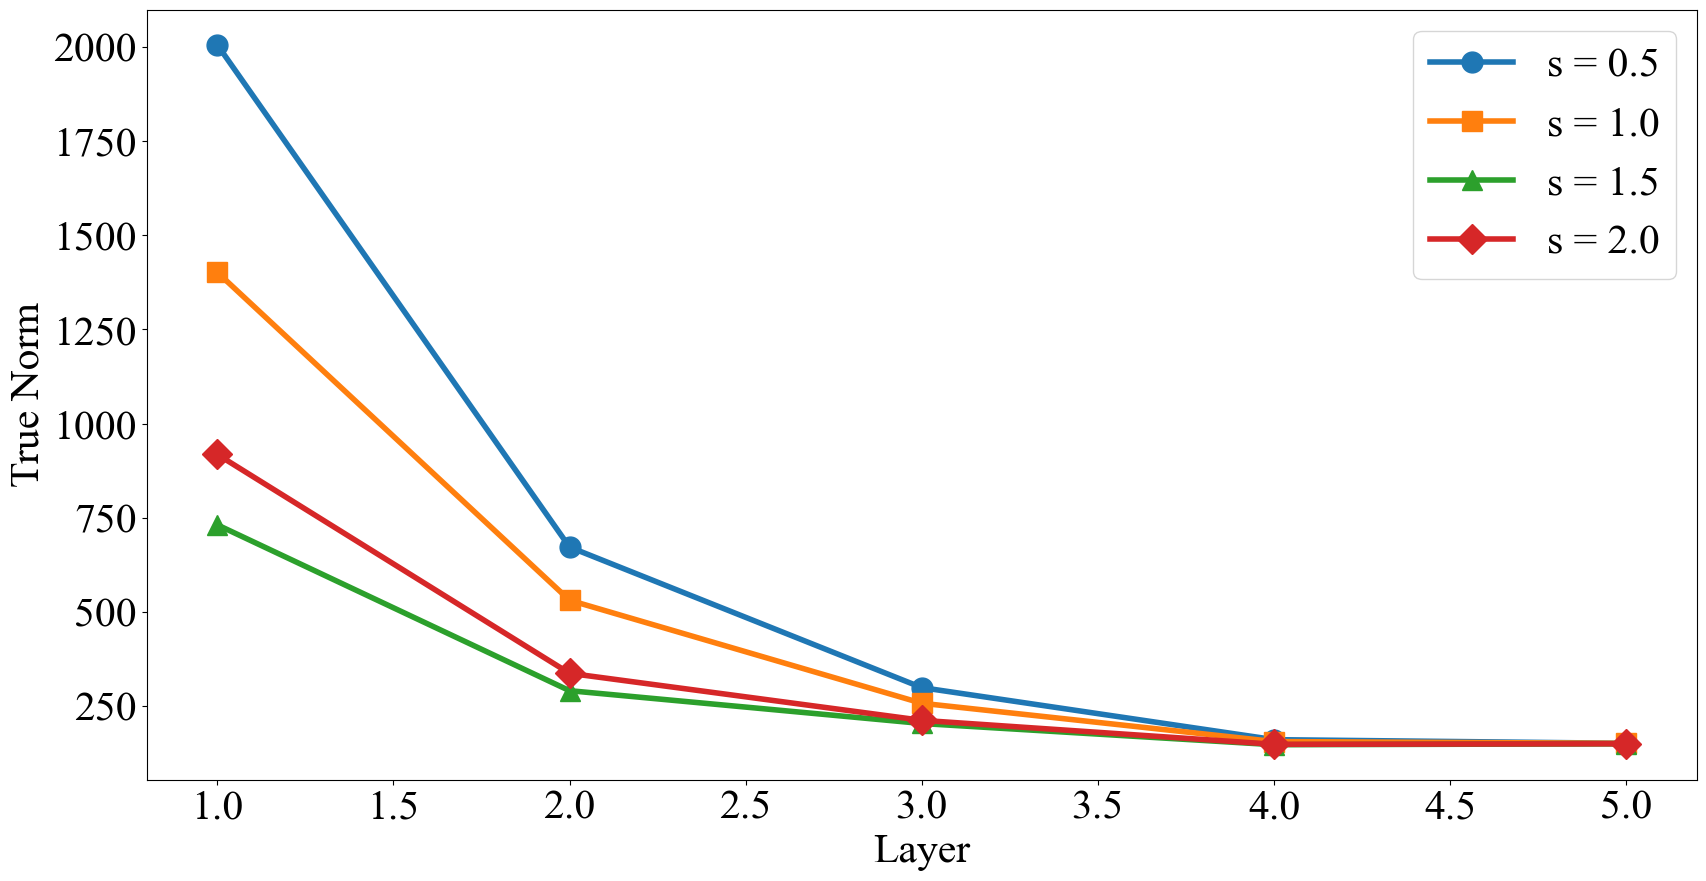

In [10]:
# Plot True Norms s 
fig, ax = plt.subplots(1, 1, figsize=(20,10))
layers = np.linspace(1, n_layers, n_layers)
print(len(layers))
for i, s in enumerate(s_vals):
    ax.plot(layers, true_norms_s[i,:,0], label = 's = ' + str(s), marker = shapes[i], markersize = markersize, linewidth = linewidth)
ax.legend()
# ax.set_yscale('log')

ax.set_xlabel('Layer')
ax.set_ylabel('True Norm')

# get slope
slopes = []
for i, s in enumerate(s_vals):
    x = layers
    y = np.log2(true_norms_s[i,:,0])
    slope = np.polyfit(x, y, 1)[0]
    slopes.append(slope)
    print('s = ', s, ' slope = ', slope, ' 2^slope = ', 2**slope)


In [11]:
# Normalize all_err_s by true_norms_s
all_err_s = np.array(all_err_s)
n_samples = all_err_s.shape[-1]
all_err_s_norm = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
for i in range(len(s_vals)):
    for j in range(n_layers):
        all_err_s_norm[i,:,j,:] = all_err_s[i,:,j,:] / true_norms_s[i,j,0]

#### Plot the results of different s inputs for random model 

findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.


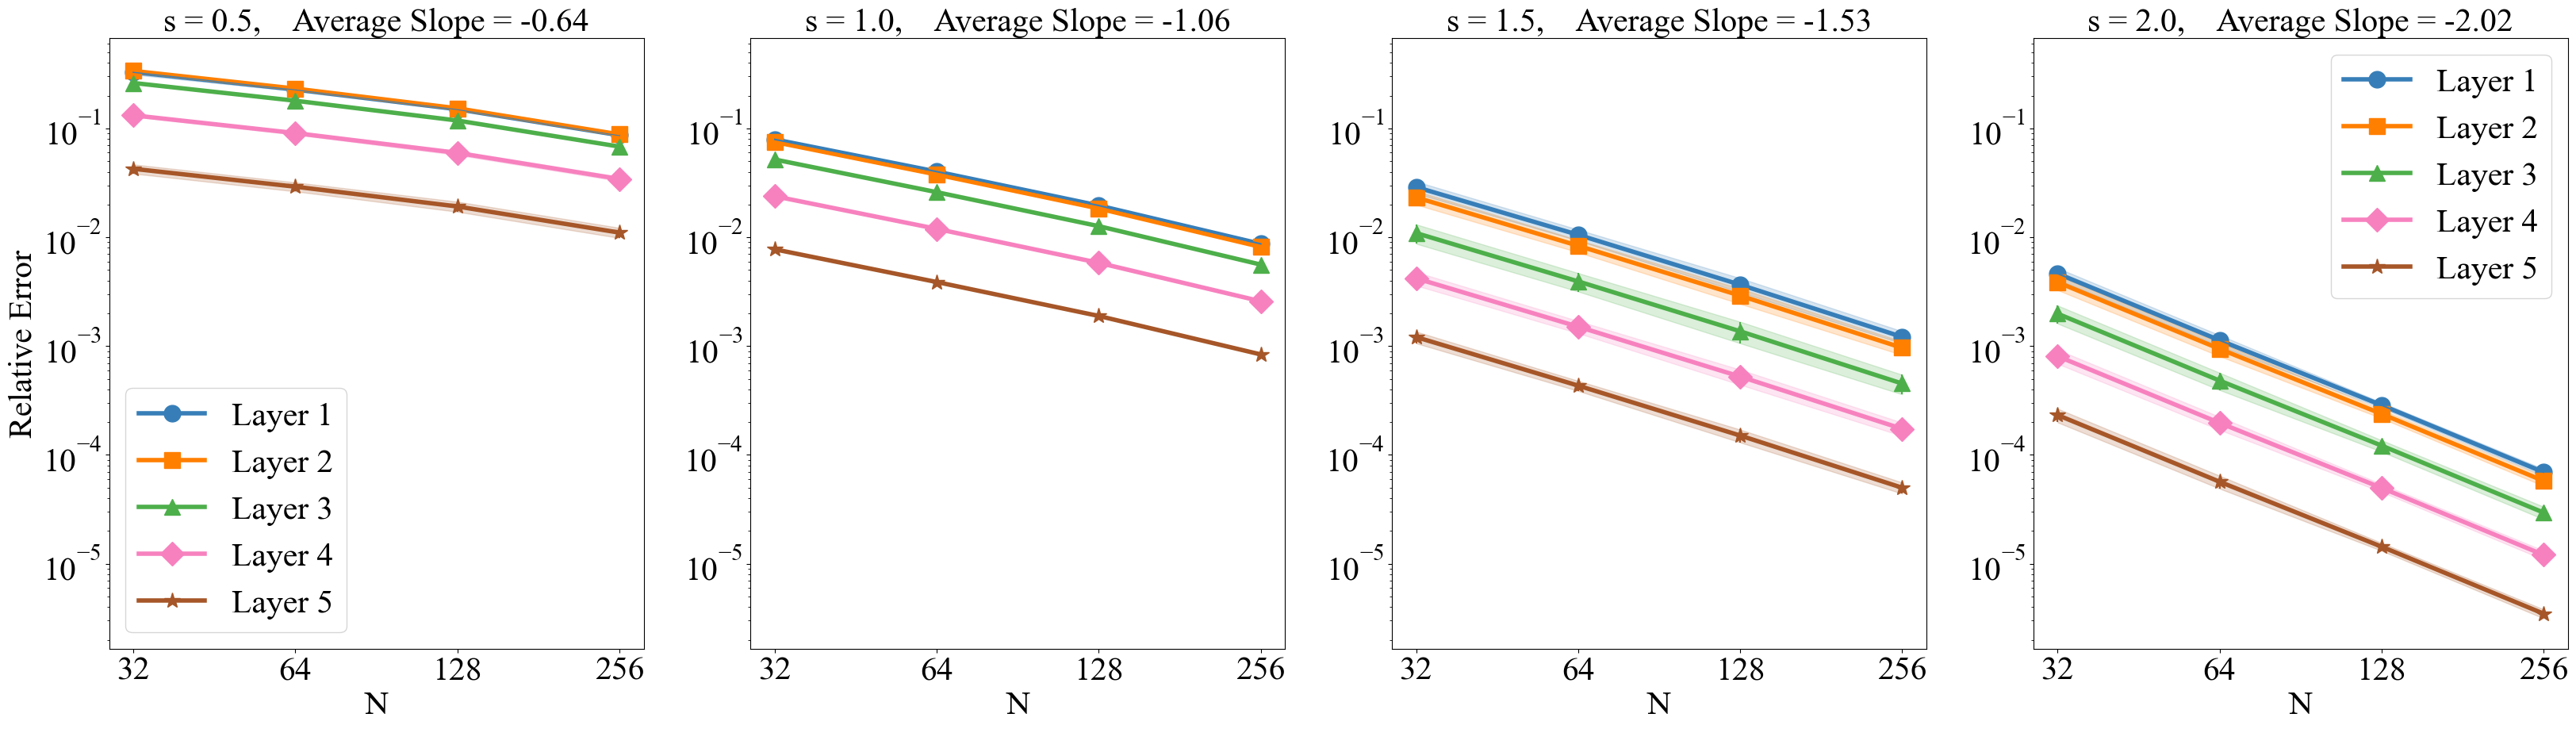

In [12]:
# Error versus N for different s
sizes_plot = sizes[:-1]
fix, ax = plt.subplots(1,4, figsize=(40, 10))

for i, s in enumerate(s_vals):
    all_err = all_err_s_norm[i]

    all_err_mean = np.mean(all_err, axis = -1)
    all_err_std = 2*np.std(all_err, axis = -1)

    slopes = []

    for layer in range(all_err.shape[1]):
        ax[i].plot(sizes_plot,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
        ax[i].errorbar(sizes_plot, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
        ax[i].fill_between(sizes_plot, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

        p = np.polyfit(np.log(sizes_plot), np.log(all_err_mean[:,layer]), 1)
        slopes.append(p[0])

    ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}') 
    # logscale
    ax[i].set_yscale('log')
    # set y range
    ax[i].set_ylim([np.min(all_err_s_norm)/2, np.max(all_err_s_norm)*2])
    ax[i].set_xscale('log') 
    ax[i].set_xlabel('N')
    ax[i].set_xticks([])
    ax[i].xaxis.set_minor_locator(plt.NullLocator())

    # no scientific notation x labels

    ax[i].set_xticks(sizes_plot, sizes_plot)
ax[0].set_ylabel('Relative Error') 
# put legend on right of all subplots
ax[0].legend()
ax[3].legend()
# save figure
plt.savefig('../Figures/Err_vs_N.pdf')



In [ ]:
# Normal model error with relu activation


### Same thing for the all 10x model

In [ ]:
all_err_s = []
true_norms_s = []
model_sample = 0
model_name = 'standard_normal_model_10x'

for s in s_vals:
    err, norms = get_err_norms(s,sizes = sizes, model_name = model_name)
    all_err_s.append(err)
    true_norms_s.append(norms)



act: gelu
gelu
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
act: gelu
gelu
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
act: gelu
gelu
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
act: gelu
gelu
<built-in function gelu>
<built-in funct

In [ ]:
true_norms_s = np.array(true_norms_s)
print(true_norms_s.shape)
print(all_err_s[0].shape)
n_layers = true_norms_s.shape[1]



(4, 6, 2)
(5, 6, 2)


6
s =  0.5  slope =  2.1035457611083994  2^slope =  4.297643346432471
Mean Multiplicative factors =  4.4245048
s =  1.0  slope =  2.13834958757673  2^slope =  4.402581122498398
Mean Multiplicative factors =  4.5356374
s =  1.5  slope =  2.0388544355119977  2^slope =  4.109191129016463
Mean Multiplicative factors =  4.253125
s =  2.0  slope =  2.127393559047154  2^slope =  4.369273933639926
Mean Multiplicative factors =  4.493766


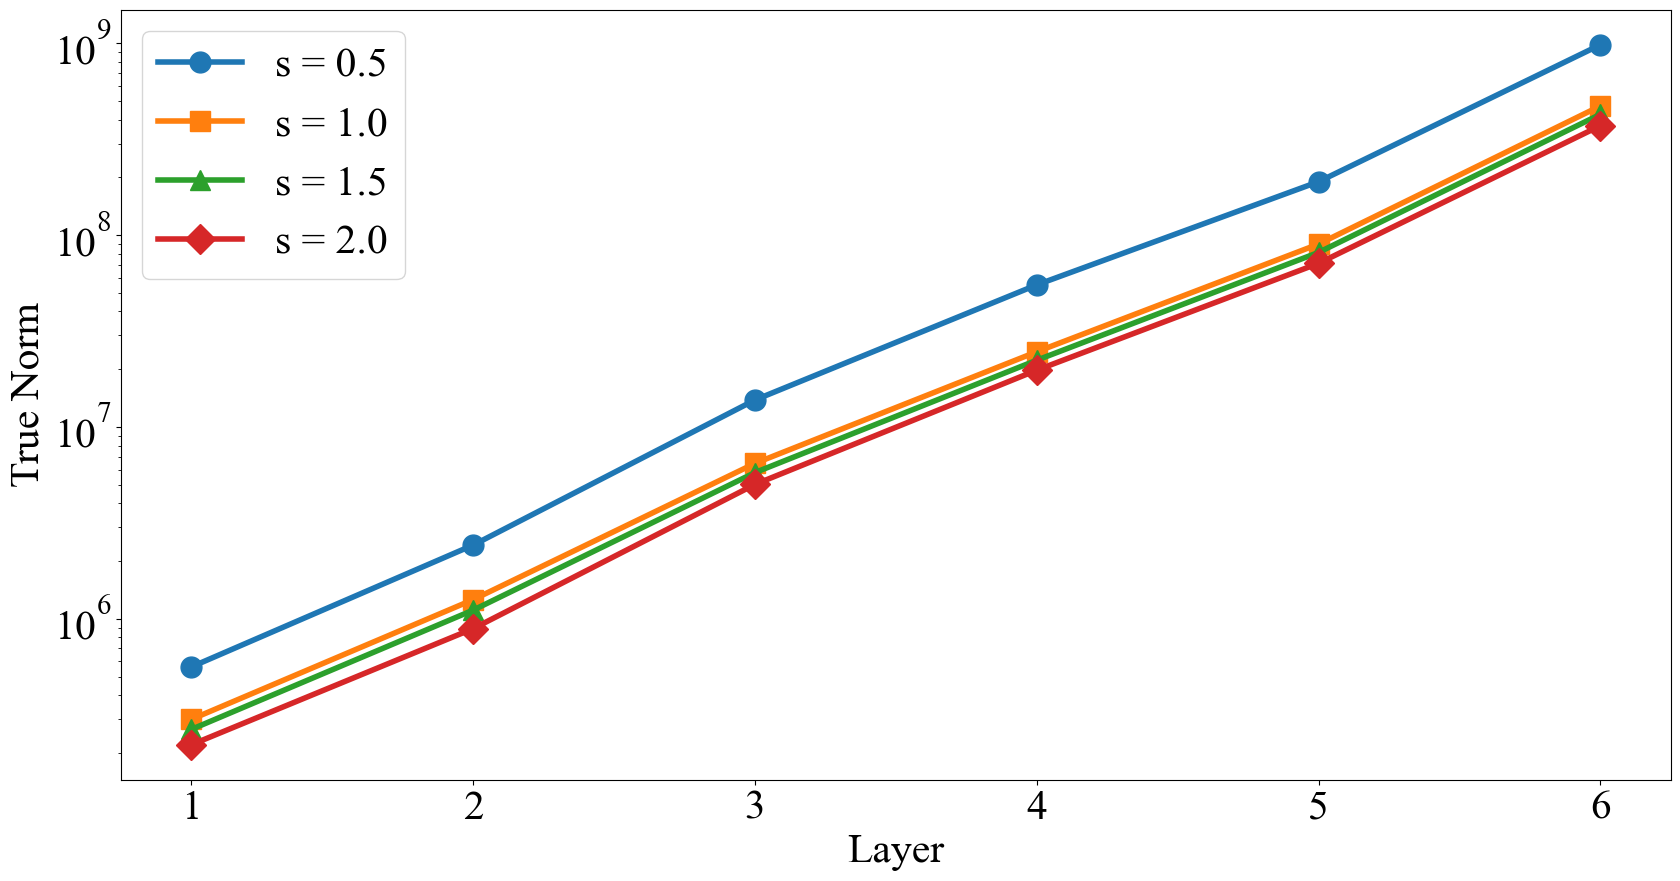

In [ ]:
# Plot True Norms s 
fig, ax = plt.subplots(1, 1, figsize=(20,10))
layers = np.linspace(1, n_layers, n_layers)
print(len(layers))
for i, s in enumerate(s_vals):
    ax.plot(layers, true_norms_s[i,:,1], label = 's = ' + str(s), marker = shapes[i], markersize = markersize, linewidth = linewidth)
ax.legend()
# ax.set_yscale('log')

ax.set_xlabel('Layer')
ax.set_ylabel('True Norm')

# get slope
slopes = []
for i, s in enumerate(s_vals):
    x = layers
    y = true_norms_s[i,:,0]
    slope = np.polyfit(x, np.log2(y), 1)[0]
    slopes.append(slope)
    print('s = ', s, ' slope = ', slope, ' 2^slope = ', 2**slope)
    mult_factors = y[1:]/y[:-1]
    print('Mean Multiplicative factors = ', np.mean(mult_factors))

ax.set_yscale('log')



In [ ]:
# Normalize all_err_s by true_norms_s
all_err_s = np.array(all_err_s)
n_samples = all_err_s.shape[-1]
all_err_s_norm = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
for i in range(len(s_vals)):
    for j in range(n_layers):
        all_err_s_norm[i,:,j,:] = all_err_s[i,:,j,:] / true_norms_s[i,j,0]

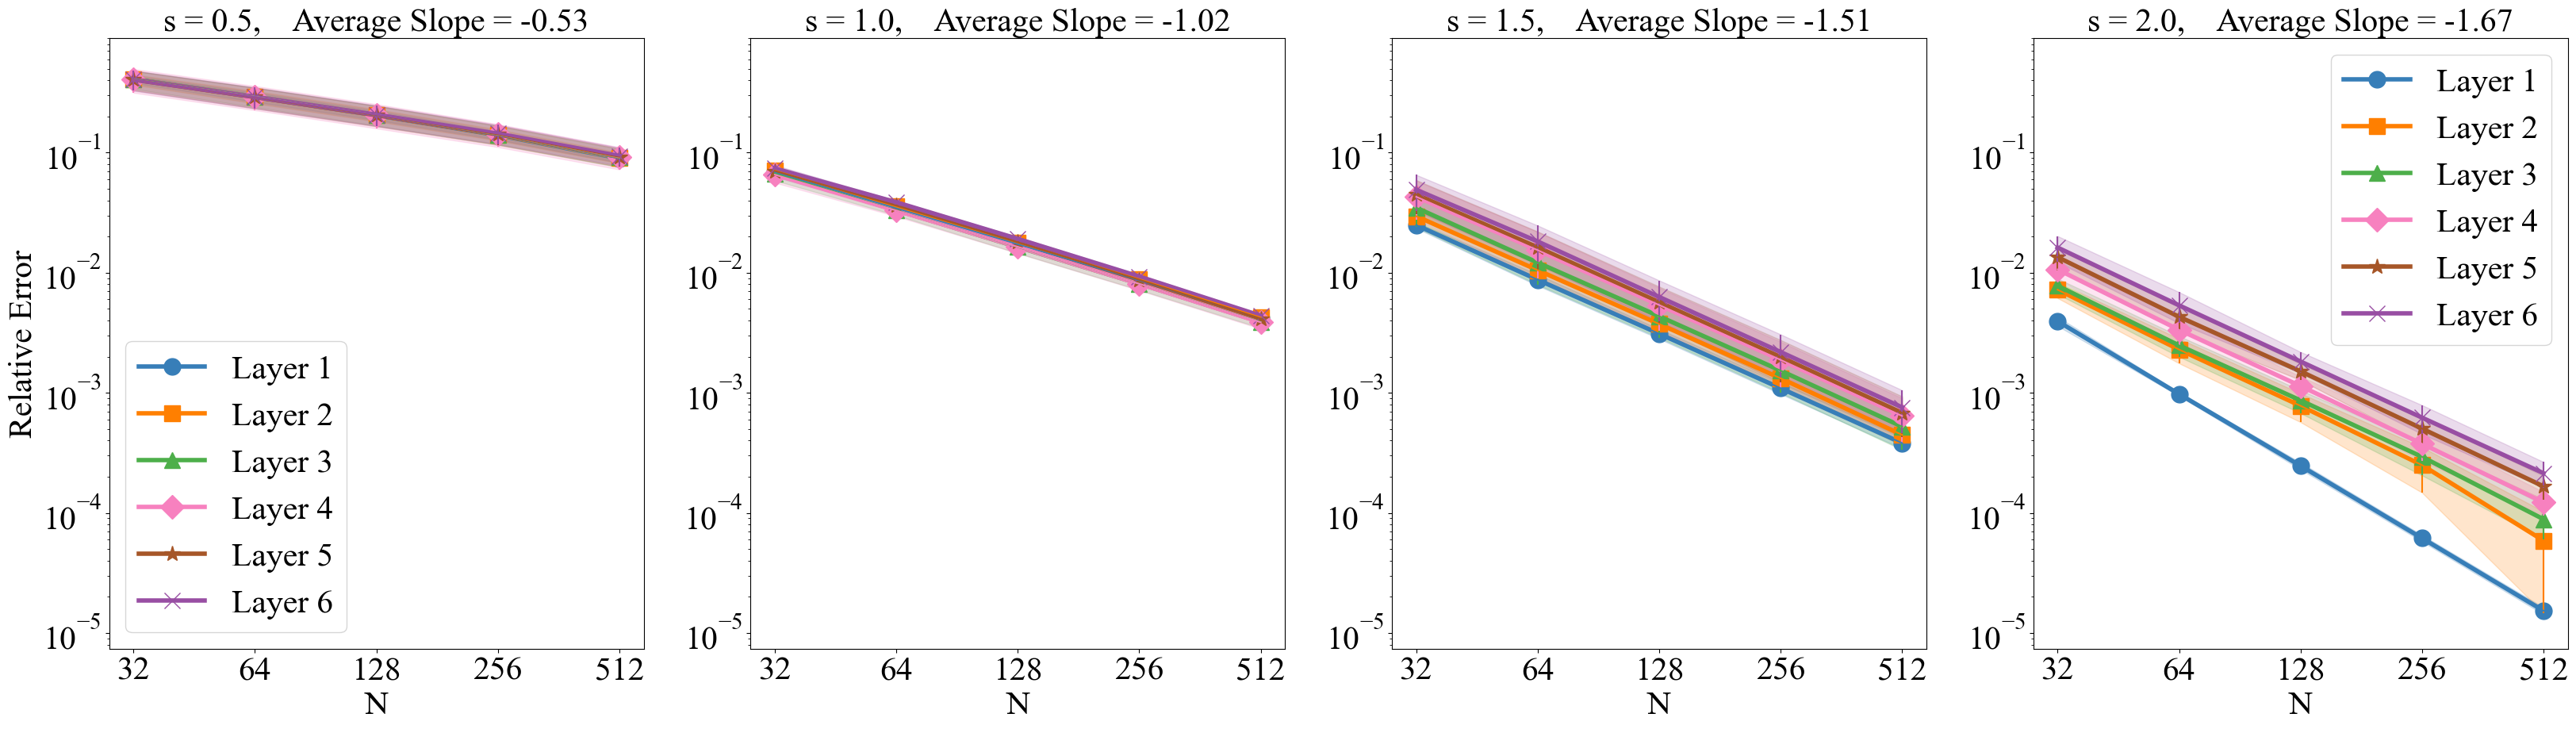

In [ ]:
# Error versus N for different s
sizes_plot = sizes[:-1]
fix, ax = plt.subplots(1,4, figsize=(40, 10))

for i, s in enumerate(s_vals):
    all_err = all_err_s_norm[i]

    all_err_mean = np.mean(all_err, axis = -1)
    all_err_std = 2*np.std(all_err, axis = -1)

    slopes = []

    for layer in range(all_err.shape[1]):
        ax[i].plot(sizes_plot,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
        ax[i].errorbar(sizes_plot, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
        ax[i].fill_between(sizes_plot, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

        p = np.polyfit(np.log(sizes_plot), np.log(all_err_mean[:,layer]), 1)
        slopes.append(p[0])

    ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}') 
    # logscale
    ax[i].set_yscale('log')
    # set y range
    ax[i].set_ylim([np.min(all_err_s_norm)/2, np.max(all_err_s_norm)*2])
    ax[i].set_xscale('log') 
    ax[i].set_xlabel('N')
    ax[i].set_xticks([])
    ax[i].xaxis.set_minor_locator(plt.NullLocator())

    # no scientific notation x labels

    ax[i].set_xticks(sizes_plot, sizes_plot)
ax[0].set_ylabel('Relative Error') 
# put legend on right of all subplots
ax[0].legend()
ax[3].legend()
# save figure
plt.savefig('../Figures/Err_vs_N_10x.pdf')



## Same thing for all 1s model

In [ ]:
all_err_s = []
true_norms_s = []
model_sample = 0
model_name = 'model_all_ones'

for s in s_vals:
    err, norms = get_err_norms(s,sizes = sizes, model_name = model_name)
    all_err_s.append(err)
    true_norms_s.append(norms)



act: gelu
gelu
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
act: gelu
gelu
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
act: gelu
gelu
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
act: gelu
gelu
<built-in function gelu>
<built-in funct

In [ ]:
true_norms_s = np.array(true_norms_s)
print(true_norms_s.shape)
print(all_err_s[0].shape)
n_layers = true_norms_s.shape[1]



(4, 6, 2)
(5, 6, 2)


6
s =  0.5  slope =  5.995246069771903  2^slope =  63.78945598663161
Mean Multiplicative factors =  63.755165
s =  1.0  slope =  5.999479021344866  2^slope =  63.97689281972447
Mean Multiplicative factors =  63.97456
s =  1.5  slope =  5.999951662336077  2^slope =  63.997855708532924
Mean Multiplicative factors =  63.997948
s =  2.0  slope =  6.000002615792412  2^slope =  64.00011604036986
Mean Multiplicative factors =  64.00043


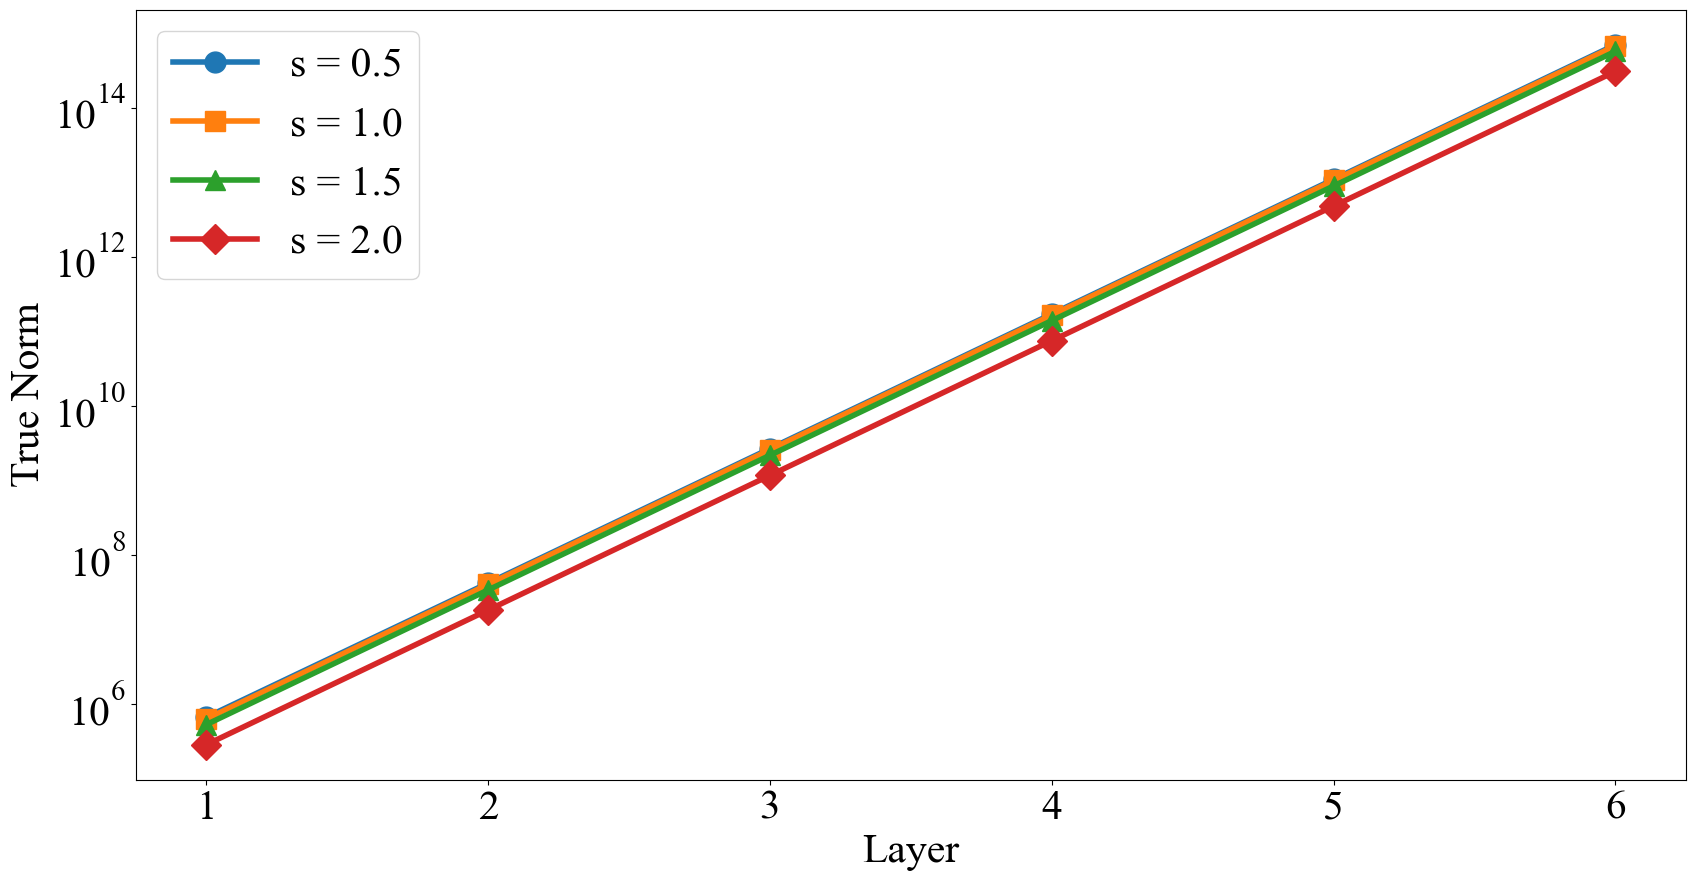

In [ ]:
# Plot True Norms s 
fig, ax = plt.subplots(1, 1, figsize=(20,10))
layers = np.linspace(1, n_layers, n_layers)
print(len(layers))
for i, s in enumerate(s_vals):
    ax.plot(layers, true_norms_s[i,:,1], label = 's = ' + str(s), marker = shapes[i], markersize = markersize, linewidth = linewidth)
ax.legend()
# ax.set_yscale('log')

ax.set_xlabel('Layer')
ax.set_ylabel('True Norm')

# get slope
slopes = []
for i, s in enumerate(s_vals):
    x = layers
    y = true_norms_s[i,:,0]
    slope = np.polyfit(x, np.log2(y), 1)[0]
    slopes.append(slope)
    print('s = ', s, ' slope = ', slope, ' 2^slope = ', 2**slope)
    mult_factors = y[1:]/y[:-1]
    print('Mean Multiplicative factors = ', np.mean(mult_factors))

ax.set_yscale('log')



In [ ]:
# Normalize all_err_s by true_norms_s
all_err_s = np.array(all_err_s)
n_samples = all_err_s.shape[-1]
all_err_s_norm = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
for i in range(len(s_vals)):
    for j in range(n_layers):
        all_err_s_norm[i,:,j,:] = all_err_s[i,:,j,:] / true_norms_s[i,j,0]

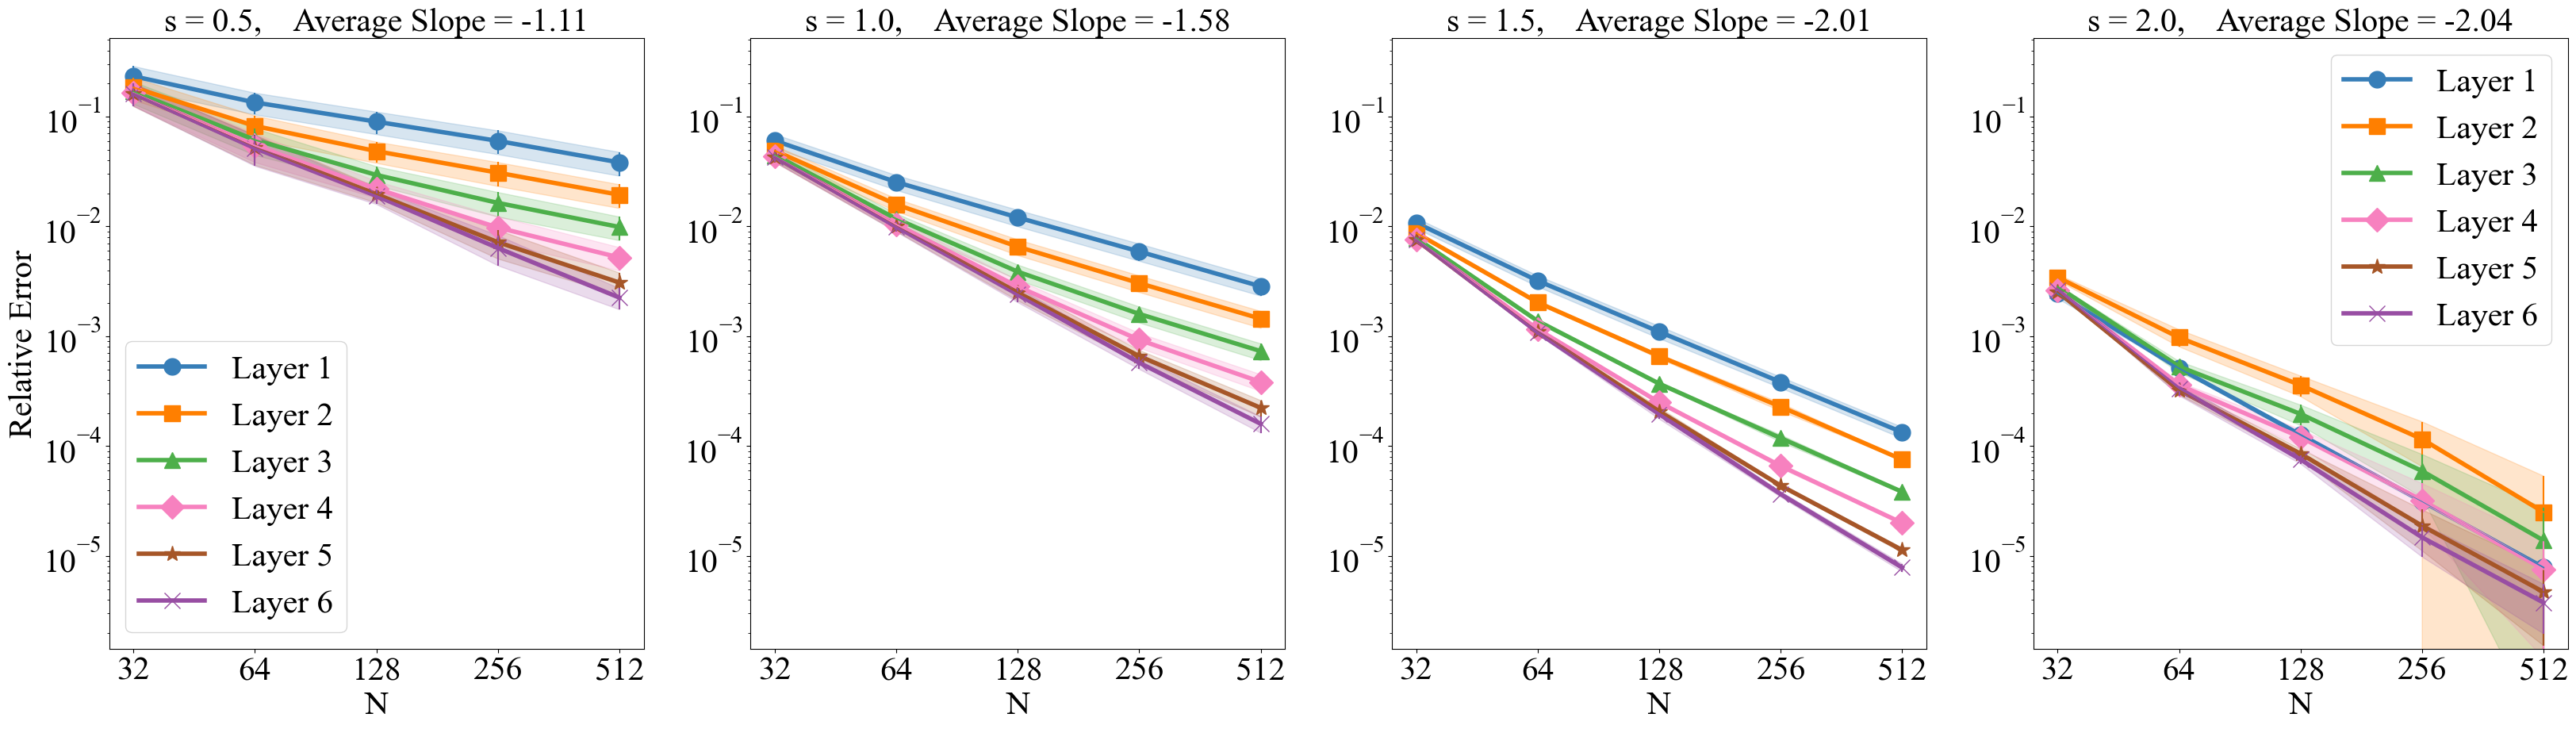

In [ ]:
# Error versus N for different s
sizes_plot = sizes[:-1]
fix, ax = plt.subplots(1,4, figsize=(40, 10))

for i, s in enumerate(s_vals):
    all_err = all_err_s_norm[i]

    all_err_mean = np.mean(all_err, axis = -1)
    all_err_std = 2*np.std(all_err, axis = -1)

    slopes = []

    for layer in range(all_err.shape[1]):
        ax[i].plot(sizes_plot,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
        ax[i].errorbar(sizes_plot, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
        ax[i].fill_between(sizes_plot, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

        p = np.polyfit(np.log(sizes_plot), np.log(all_err_mean[:,layer]), 1)
        slopes.append(p[0])

    ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}') 
    # logscale
    ax[i].set_yscale('log')
    # set y range
    ax[i].set_ylim([np.min(all_err_s_norm)/2, np.max(all_err_s_norm)*2])
    ax[i].set_xscale('log') 
    ax[i].set_xlabel('N')
    ax[i].set_xticks([])
    ax[i].xaxis.set_minor_locator(plt.NullLocator())

    # no scientific notation x labels

    ax[i].set_xticks(sizes_plot, sizes_plot)
ax[0].set_ylabel('Relative Error') 
# put legend on right of all subplots
ax[0].legend()
ax[3].legend()
# save figure
plt.savefig('../Figures/Err_vs_N_all1s.pdf')

## Error versus N for the relu activation standard normal model

In [ ]:
all_err_s = []
true_norms_s = []
model_sample = 0
model_name = 'standard_normal_model_relu'

for s in s_vals:
    err, norms = get_err_norms(s,sizes = sizes, model_name = model_name)
    all_err_s.append(err)
    true_norms_s.append(norms)


act: relu
relu
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
act: relu
relu
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0>
<built-in method relu_ of type object at 0x1161cd7a0

In [ ]:
true_norms_s = np.array(true_norms_s)
print(true_norms_s.shape)
print(all_err_s[0].shape)
n_layers = true_norms_s.shape[1]



(4, 6, 2)
(5, 6, 2)


6
s =  0.5  slope =  -0.5407147816249306  2^slope =  0.6874302381509839
Mean Multiplicative factors =  0.76642
s =  1.0  slope =  -0.538647488185338  2^slope =  0.6884159895791025
Mean Multiplicative factors =  0.7685534
s =  1.5  slope =  -0.33717128208705366  2^slope =  0.7915918795787352
Mean Multiplicative factors =  0.8530369
s =  2.0  slope =  -0.4371560505458285  2^slope =  0.7385891372408561
Mean Multiplicative factors =  0.8105486


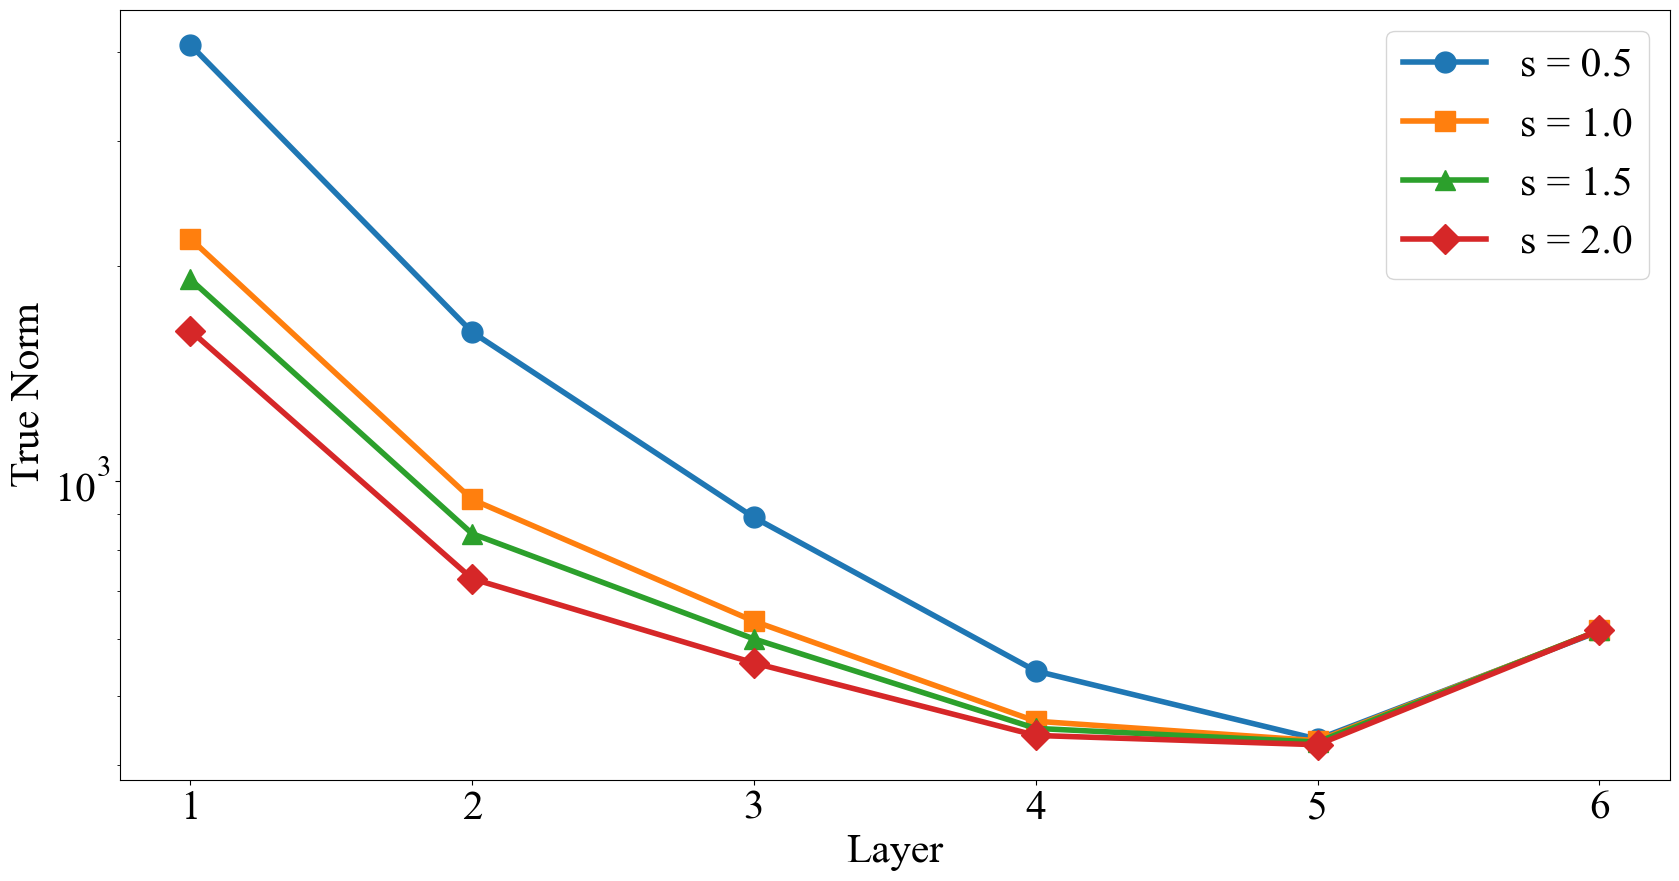

In [ ]:
# Plot True Norms s 
fig, ax = plt.subplots(1, 1, figsize=(20,10))
layers = np.linspace(1, n_layers, n_layers)
print(len(layers))
for i, s in enumerate(s_vals):
    ax.plot(layers, true_norms_s[i,:,1], label = 's = ' + str(s), marker = shapes[i], markersize = markersize, linewidth = linewidth)
ax.legend()
# ax.set_yscale('log')

ax.set_xlabel('Layer')
ax.set_ylabel('True Norm')

# get slope
slopes = []
for i, s in enumerate(s_vals):
    x = layers
    y = true_norms_s[i,:,0]
    slope = np.polyfit(x, np.log2(y), 1)[0]
    slopes.append(slope)
    print('s = ', s, ' slope = ', slope, ' 2^slope = ', 2**slope)
    mult_factors = y[1:]/y[:-1]
    print('Mean Multiplicative factors = ', np.mean(mult_factors))

ax.set_yscale('log')



In [ ]:
# Normalize all_err_s by true_norms_s
all_err_s = np.array(all_err_s)
n_samples = all_err_s.shape[-1]
all_err_s_norm = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
for i in range(len(s_vals)):
    for j in range(n_layers):
        all_err_s_norm[i,:,j,:] = all_err_s[i,:,j,:] / true_norms_s[i,j,0]

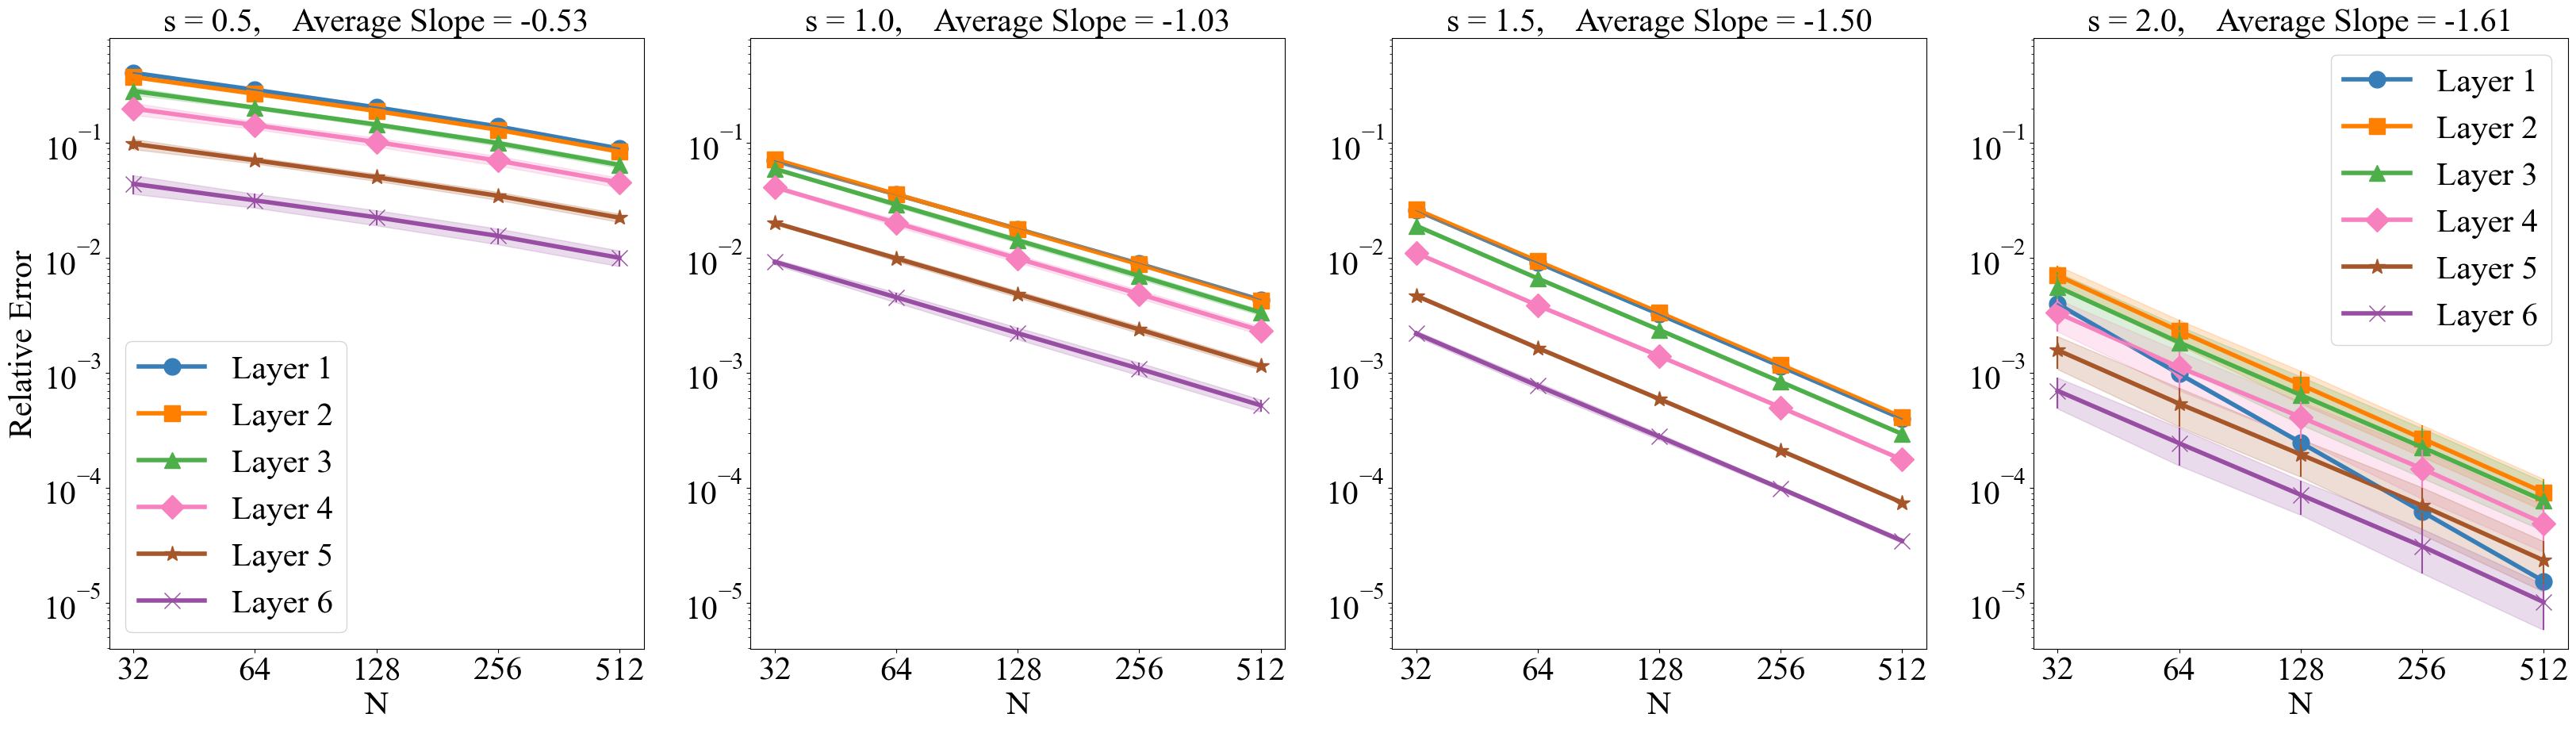

In [ ]:
# Error versus N for different s
sizes_plot = sizes[:-1]
fix, ax = plt.subplots(1,4, figsize=(40, 10))

for i, s in enumerate(s_vals):
    all_err = all_err_s_norm[i]

    all_err_mean = np.mean(all_err, axis = -1)
    all_err_std = 2*np.std(all_err, axis = -1)

    slopes = []

    for layer in range(all_err.shape[1]):
        ax[i].plot(sizes_plot,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
        ax[i].errorbar(sizes_plot, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
        ax[i].fill_between(sizes_plot, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

        p = np.polyfit(np.log(sizes_plot), np.log(all_err_mean[:,layer]), 1)
        slopes.append(p[0])

    ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}') 
    # logscale
    ax[i].set_yscale('log')
    # set y range
    ax[i].set_ylim([np.min(all_err_s_norm)/2, np.max(all_err_s_norm)*2])
    ax[i].set_xscale('log') 
    ax[i].set_xlabel('N')
    ax[i].set_xticks([])
    ax[i].xaxis.set_minor_locator(plt.NullLocator())

    # no scientific notation x labels

    ax[i].set_xticks(sizes_plot, sizes_plot)
ax[0].set_ylabel('Relative Error') 
# put legend on right of all subplots
ax[0].legend()
ax[3].legend()
# save figure
plt.savefig('../Figures/Err_vs_N_relu.pdf')

## Examine stability of FNO model 

### Create perturbed inputs 

In [ ]:
per_size = 512
input_i = 0 
s = 1.5
true_input_path = '../data/GRF_s' + str(s) +'_GRF_size_' + str(per_size) + '_' + str(input_i)+ '.pkl'
input_true = load_data(true_input_path)
input_true = input_true.unsqueeze(0).unsqueeze(0)

perturb_input_path = '../data/GRF_s' + str(s) +'_GRF_size_' + str(per_size) + '_' + str(input_i+1)+ '.pkl'
input_perturb = load_data(perturb_input_path)
input_perturb = input_perturb.unsqueeze(0).unsqueeze(0)

model_info_path = '../models/initial_models/standard_normal_model_info.yaml'
model_path = '../models/initial_models/standard_normal_model.pt'
model = load_model(model_info_path, model_path,s_outputspace = (per_size,per_size))
model_info = load_model_info(model_info_path)
n_layers = model_info['n_layers']

model_info_path_10x = '../models/initial_models/standard_normal_model_10x_info.yaml'
model_path_10x = '../models/initial_models/standard_normal_model_10x.pt'
model_10x = load_model(model_info_path_10x,model_path_10x,s_outputspace = (per_size,per_size))

model_info_path_all_ones = '../models/initial_models/model_all_ones_info.yaml'
model_path_all_ones = '../models/initial_models/model_all_ones.pt'
model_all_ones = load_model(model_info_path_all_ones, model_path_all_ones,s_outputspace = (per_size,per_size))

# scales = [0.01,0.02,0.03,0.04] #,0.05,0.06,0.07,0.08,0.09,0.1]
scales = [0.0001, 0.001, 0.01, 0.1, 1]
def compute_perturb_err(model, input_true, input_perturb, scales):
    perturb_norms = []
    true_norms = []
    perturb_err = np.zeros((len(scales),n_layers))
    layers_true = get_layer_output(model,input_true)
    for i, scale in enumerate(scales):
        input_perturb_i = input_true + scale*input_perturb
        perturb_norm = torch.norm(input_perturb*scale)/per_size
        perturb_norms.append(perturb_norm)
        layers_perturb = get_layer_output(model,input_perturb_i)
        for layer in range(n_layers):
            err = torch.norm(layers_perturb[layer] - layers_true[layer])/per_size
            true_norm = torch.norm(layers_true[layer])/per_size
            perturb_err[i,layer] = err #/true_norm
            if i == 0:
                true_norms.append(true_norm)

    perturb_norms = np.array(perturb_norms)
    true_norms = np.array(true_norms)
    return perturb_err, perturb_norms, true_norms


act: gelu
act: gelu
act: gelu


#### Plot perturbation error

In [ ]:

perturb_err,perturb_norms, true_norms = compute_perturb_err(model, input_true, input_perturb, scales)
perturb_err_all_ones,perturb_norms_ones, true_norms_ones = compute_perturb_err(model_all_ones, input_true, input_perturb, scales)
perturb_err_10x,perturb_norms_10x, true_norms_10x = compute_perturb_err(model_10x, input_true, input_perturb, scales)


<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>
<built-in function gelu>


#### Plot true norms

Text(0, 0.5, 'State Norm')

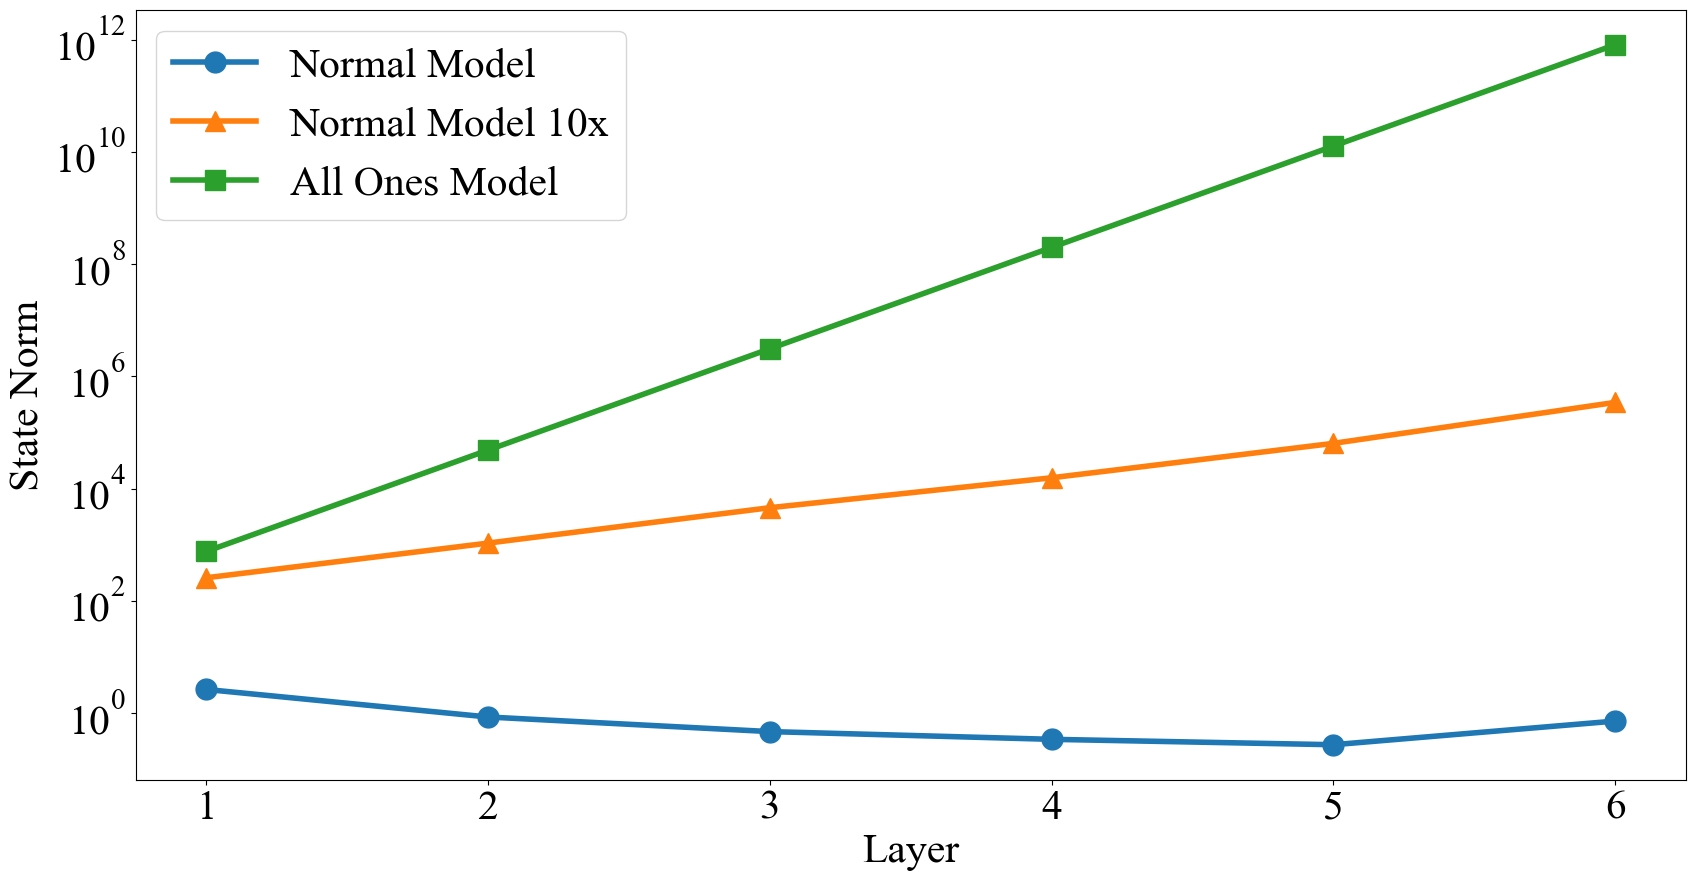

In [ ]:
# Plot true norms versus layers
fig, ax = plt.subplots(1, 1, figsize=(20,10))
layers = np.linspace(1, n_layers, n_layers)
ax.plot(layers, true_norms, label = 'Normal Model', marker = 'o', markersize = markersize, linewidth = linewidth)
ax.plot(layers, true_norms_10x, label = 'Normal Model 10x', marker = '^', markersize = markersize, linewidth = linewidth)
ax.plot(layers, true_norms_ones, label = 'All Ones Model', marker = 's', markersize = markersize, linewidth = linewidth)
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Layer')
ax.set_ylabel('State Norm')


### Difference of state versus layer for normal and 1s models

Perturb_err shape =  (5, 6)
Perturb_norms shape =  (5,)
True_norms shape =  (6,)


Text(0, 0.5, 'Relative Error')

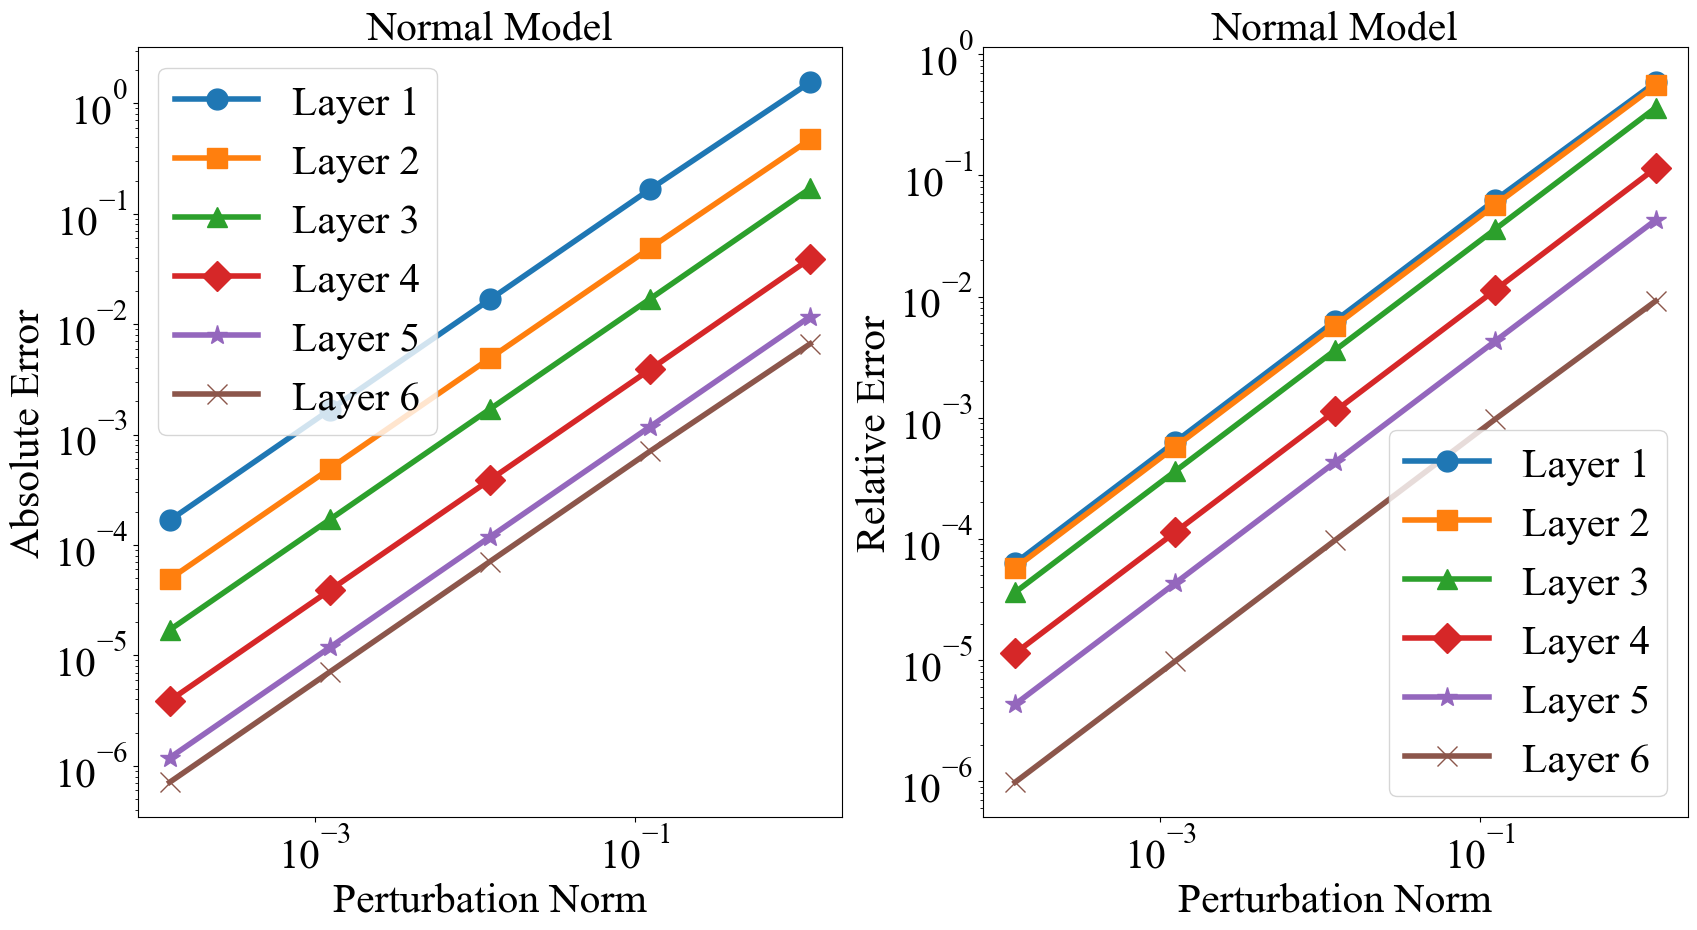

In [ ]:
# Plot Absolute and Relative Error versus Perturbation Norms for Each model
fig, ax = plt.subplots(1, 2, figsize=(20,10))
layers = np.linspace(1, n_layers, n_layers)
print("Perturb_err shape = ", perturb_err.shape)
print("Perturb_norms shape = ", perturb_norms.shape)
print("True_norms shape = ", true_norms.shape)
for i in range(n_layers):
    ax[0].plot(perturb_norms, perturb_err[:,i], label = f'Layer {i+1}', marker = shapes[i], markersize = markersize, linewidth = linewidth)
    ax[1].plot(perturb_norms, perturb_err[:,i]/true_norms[i], label = f'Layer {i+1}', marker = shapes[i], markersize = markersize, linewidth = linewidth)
for i in range(2):
    ax[i].set_xlabel('Perturbation Norm')
    ax[i].set_title('Normal Model')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].legend()
ax[0].set_ylabel('Absolute Error')
ax[1].set_ylabel('Relative Error')

# ax[0].plot(layers, perturb_err[0,:], label = 'Layer 1', marker = 'o', markersize = markersize, linewidth = linewidth)

Text(0, 0.5, 'Relative Error')

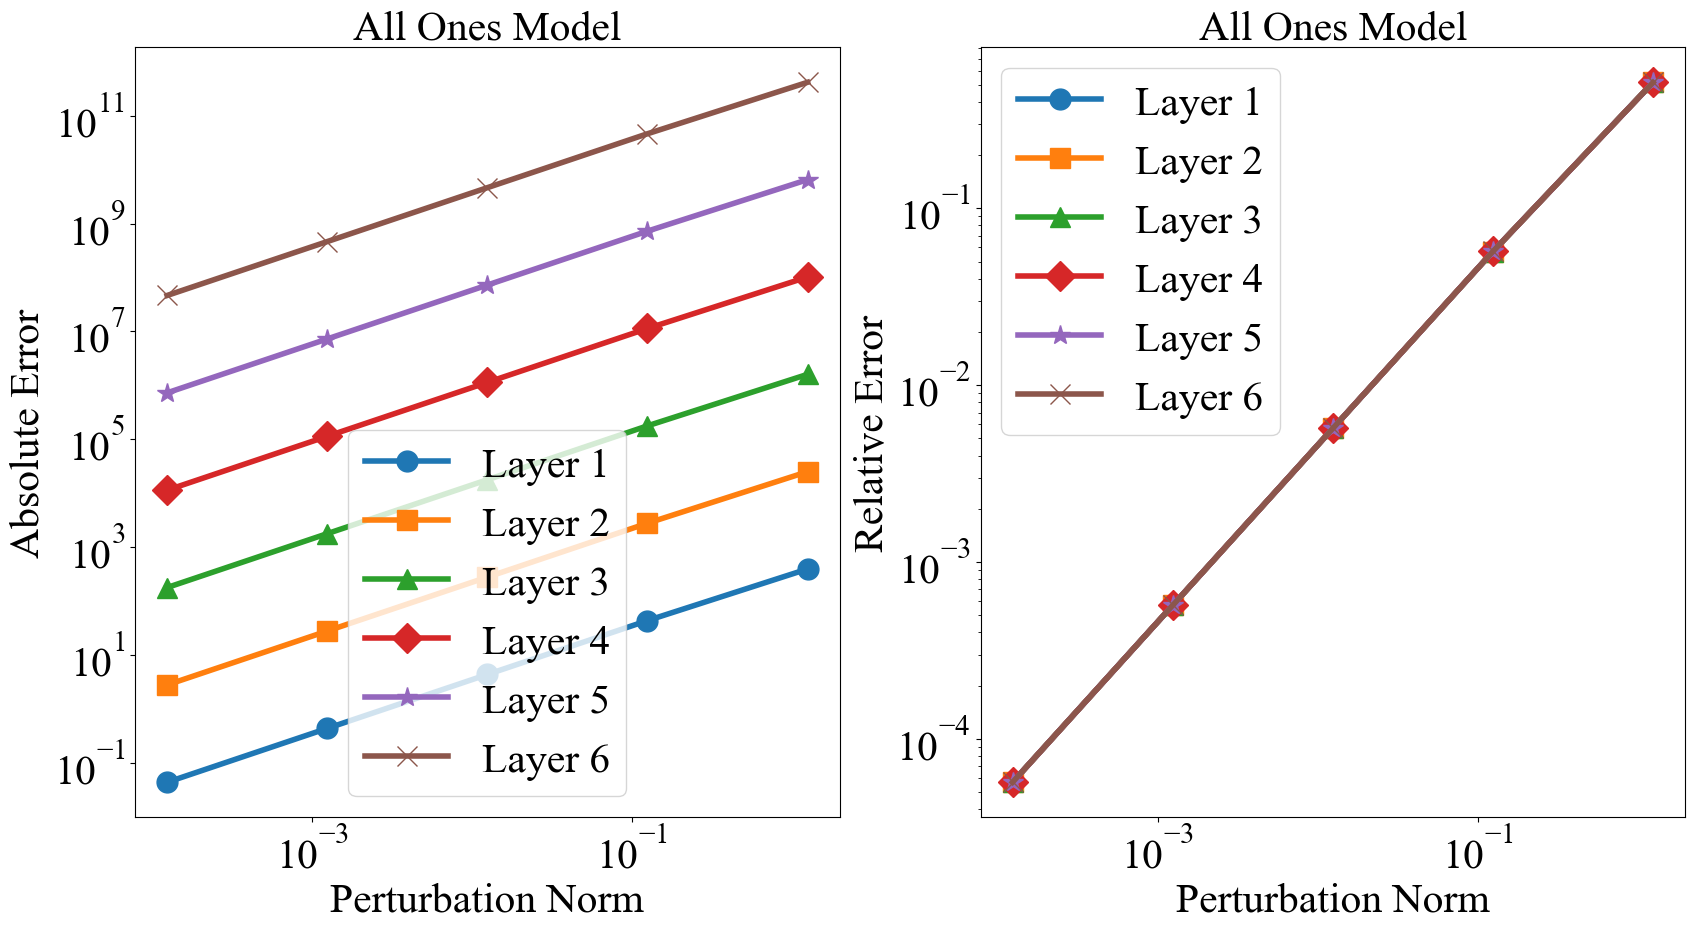

In [ ]:
# Plot the same for all ones model
fig, ax = plt.subplots(1, 2, figsize=(20,10))
for i in range(n_layers):
    ax[0].plot(perturb_norms_ones, perturb_err_all_ones[:,i], label = f'Layer {i+1}', marker = shapes[i], markersize = markersize, linewidth = linewidth)
    ax[1].plot(perturb_norms_ones, perturb_err_all_ones[:,i]/true_norms_ones[i], label = f'Layer {i+1}', marker = shapes[i], markersize = markersize, linewidth = linewidth)
for i in range(2):
    ax[i].set_xlabel('Perturbation Norm')
    ax[i].set_title('All Ones Model')
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
ax[0].set_ylabel('Absolute Error')
ax[1].set_ylabel('Relative Error')


Normal Model Slopes =  [0.9932030414262086, 0.9960736899970462, 0.999511207618608, 1.0006446517483663, 0.9990176423086039, 0.9940188649178566]
Normal Model 10x Slopes =  [0.9968206744694468, 0.995043431596686, 1.000646398360782, 0.9984469848981589, 0.9889287253428274, 0.9847480202777743]
All Ones Model Slopes =  [0.9913524788571555, 0.9912471828730787, 0.9911509845939962, 0.9911455797095172, 0.9911012684300167, 0.9910873714408621]


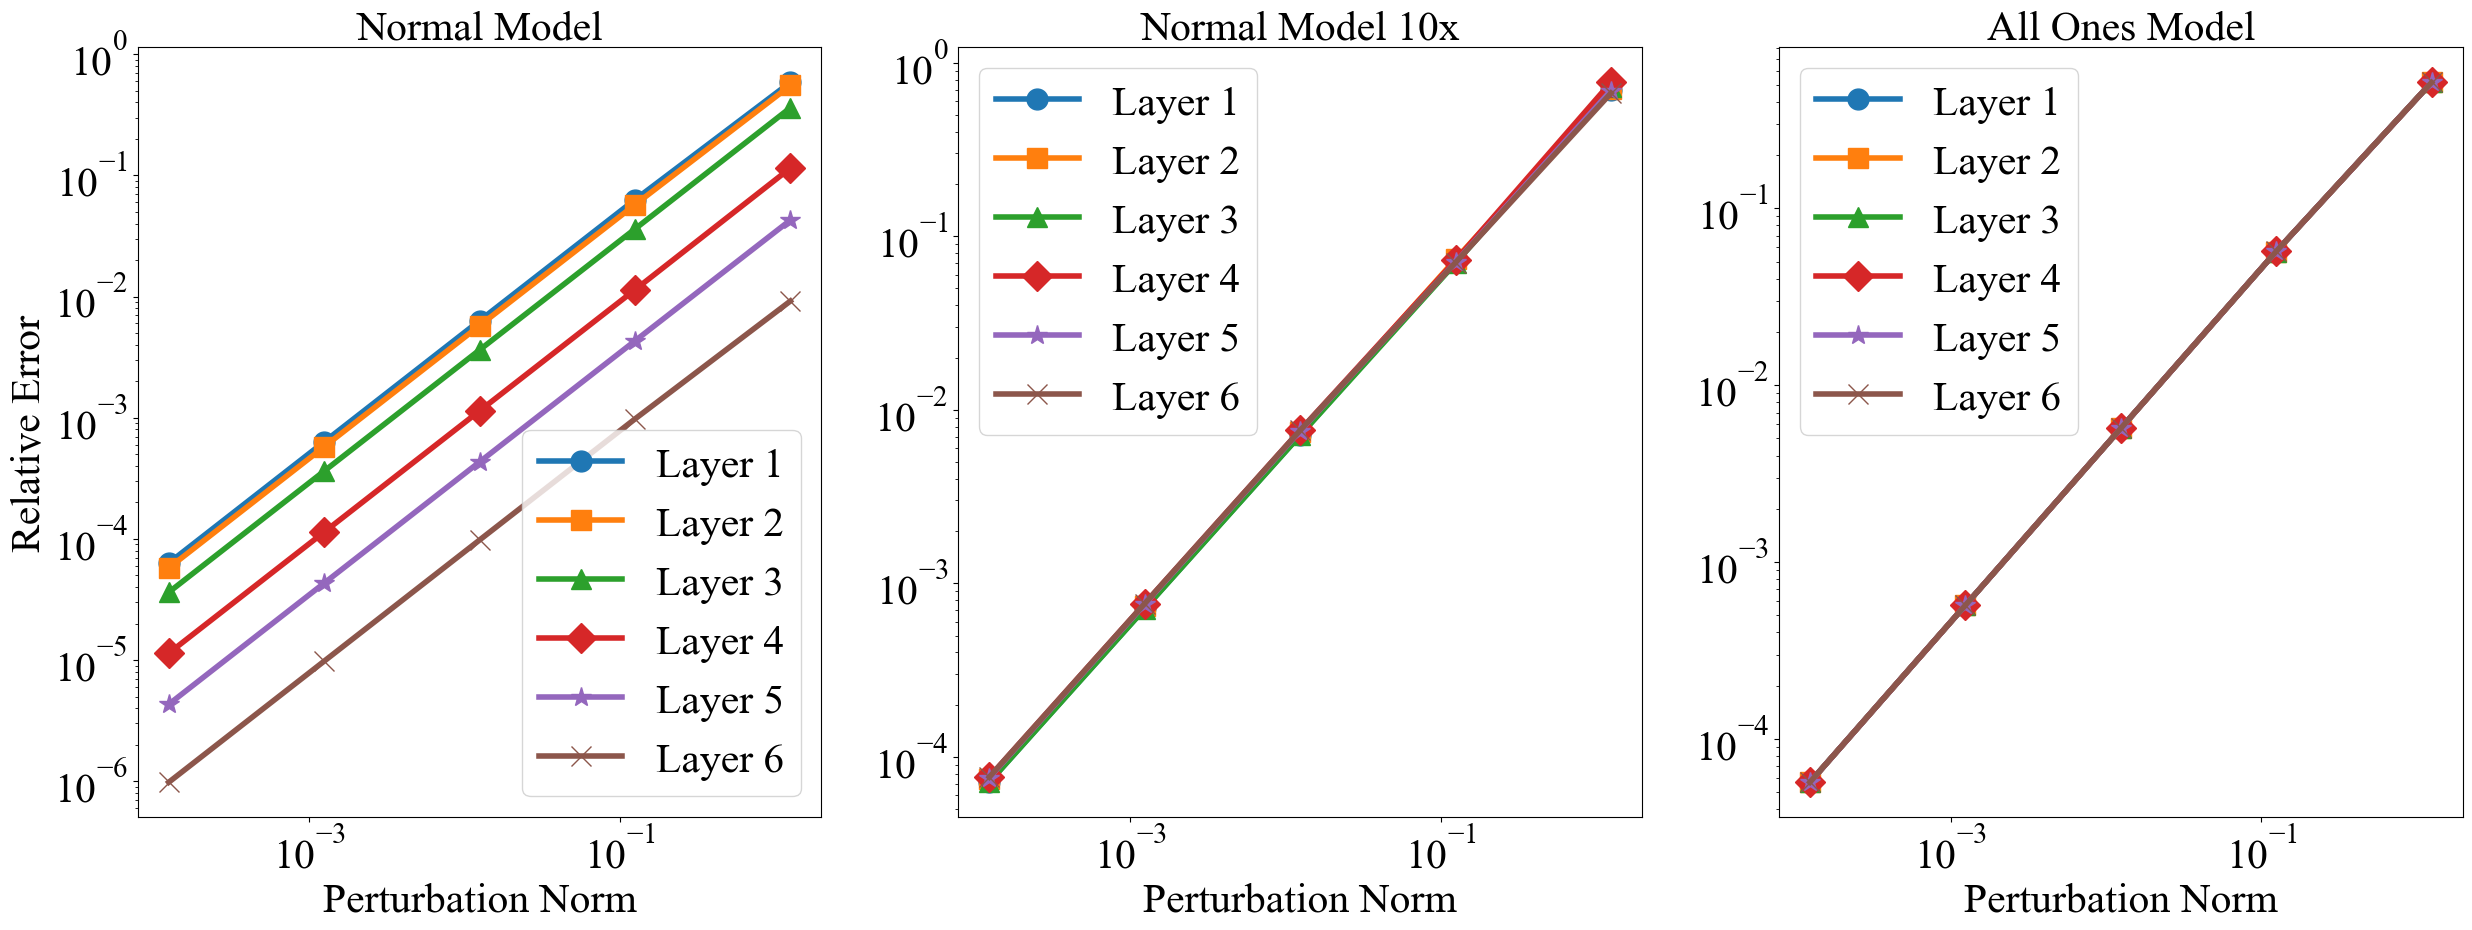

In [ ]:
# Plot relative error for the three models 
fig, ax,  = plt.subplots(1, 3, figsize=(30,10))
for i in range(n_layers):
    ax[0].plot(perturb_norms, perturb_err[:,i]/true_norms[i], label = f'Layer {i+1}', marker = shapes[i], markersize = markersize, linewidth = linewidth)
    ax[1].plot(perturb_norms_10x, perturb_err_10x[:,i]/true_norms_10x[i], label = f'Layer {i+1}', marker = shapes[i], markersize = markersize, linewidth = linewidth)
    ax[2].plot(perturb_norms_ones, perturb_err_all_ones[:,i]/true_norms_ones[i], label = f'Layer {i+1}', marker = shapes[i], markersize = markersize, linewidth = linewidth)

for i in range(3):
    ax[i].set_xlabel('Perturbation Norm')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].legend()

# slopes
slopes_normal = []
slopes_10x = []
slopes_ones = []
for i in range(n_layers):
    p = np.polyfit(np.log(perturb_norms), np.log(perturb_err[:,i]/true_norms[i]), 1)
    slopes_normal.append(p[0])
    p = np.polyfit(np.log(perturb_norms_10x), np.log(perturb_err_10x[:,i]/true_norms_10x[i]), 1)
    slopes_10x.append(p[0])
    p = np.polyfit(np.log(perturb_norms_ones), np.log(perturb_err_all_ones[:,i]/true_norms_ones[i]), 1)
    slopes_ones.append(p[0])

print('Normal Model Slopes = ', slopes_normal)
print('Normal Model 10x Slopes = ', slopes_10x)
print('All Ones Model Slopes = ', slopes_ones)
ax[0].set_ylabel('Relative Error')

ax[0].set_title('Normal Model')
ax[1].set_title('Normal Model 10x')
ax[2].set_title('All Ones Model')

# save figure
plt.savefig('../Figures/Relative_Errors_Perturbations.pdf')